In [409]:
from sympy import *
import pandas as pd
import uncertainties as unc
import uncertainties.umath as umath
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import curve_fit
import numpy as np
import os
init_printing()

# Actual results

In [410]:
data_acceleration1 = pd.read_csv("data/11A.csv")
data_acceleration1 = data_acceleration1[data_acceleration1[' time'] > 0.6]
data_force1 = pd.read_csv("data/11F.csv")
data_force1  = data_force1 [data_force1 [' time'] > 0.6]

data_acceleration2 = pd.read_csv("data/12A.csv")
data_acceleration2 = data_acceleration2[data_acceleration2[' time'] > 0.5]
data_force2 = pd.read_csv("data/12F.csv")
data_force2 = data_force2[data_force2[' time'] > 0.5]

data_acceleration3 = pd.read_csv("data/13A.csv")
data_acceleration3 = data_acceleration3[data_acceleration3[' time'] > 1.0]
data_force3 = pd.read_csv("data/13F.csv")
data_force3 = data_force3[data_force3[' time'] > 1.0]

data_acceleration4 = pd.read_csv("data/14A.csv")
data_acceleration4 = data_acceleration4[data_acceleration4[' time'] > 0.5]
data_force4 = pd.read_csv("data/14F.csv")
data_force4 = data_force4[data_force4[' time'] > 0.5]

data_acceleration5 = pd.read_csv("data/15A.csv")
data_acceleration5 = data_acceleration5[data_acceleration5[' time'] > 0.5]
data_force5 = pd.read_csv("data/15F.csv")
data_force5 = data_force5[data_force5[' time'] > 0.5]

data_acceleration6 = pd.read_csv("data/16A.csv")
data_acceleration6 = data_acceleration6[data_acceleration6[' time'] > 0.75]
data_force6 = pd.read_csv("data/16F.csv")
data_force6 = data_force6[data_force6[' time'] > 0.75]

data_acceleration7 = pd.read_csv("data/17A.csv")
data_acceleration7 = data_acceleration7[data_acceleration7[' time'] > 0.5]
data_force7 = pd.read_csv("data/17F.csv")
data_force7 = data_force7[data_force7[' time'] > 0.5]

data_acceleration8 = pd.read_csv("data/18A.csv")
data_acceleration8 = data_acceleration8[data_acceleration8[' time'] > 0.5]
data_force8 = pd.read_csv("data/18F.csv")
data_force8 = data_force8[data_force8[' time'] > 0.5]

data_acceleration9 = pd.read_csv("data/19A.csv")
data_acceleration9 = data_acceleration9[data_acceleration9[' time'] > 0.5]
data_force9 = pd.read_csv("data/19F.csv")
data_force9 = data_force9[data_force9[' time'] > 0.5]

data_acceleration10 = pd.read_csv("data/110A.csv")
data_acceleration10 = data_acceleration10[data_acceleration10[' time'] > 0.5]
data_force10 = pd.read_csv("data/110F.csv")
data_force10 = data_force10[data_force10[' time'] > 0.5]

DataTest1Acceleration = [
    data_acceleration1, data_acceleration2, data_acceleration3, data_acceleration4, data_acceleration5,
    data_acceleration6, data_acceleration7, data_acceleration8, data_acceleration9, data_acceleration10
]
DataTest1Force = [
    data_force1, data_force2, data_force3, data_force4, data_force5,
    data_force6, data_force7, data_force8, data_force9, data_force10
]



In [411]:
def set_time_to_zero_at_force_zero(force_df, accel_df, threshold=0.5):
    """
    Finds the point where force is closest to zero (within a threshold)
    and normalizes the time axis for both DataFrames around that point.

    Args:
        force_df (pd.DataFrame): DataFrame with force data.
        accel_df (pd.DataFrame): DataFrame with acceleration data.
        threshold (float): The maximum absolute force to be considered "close to zero".

    Returns:
        tuple: A tuple of new (force_df, accel_df) with normalized time.
    """
    # 1. Create copies to avoid modifying the original data
    force_df_copy = force_df.copy()
    accel_df_copy = accel_df.copy()

    # 2. Find all indices where the force is below the threshold
    candidate_indices = force_df_copy.index[force_df_copy[' cal[0]'].abs() < threshold]
    
    if candidate_indices.empty:
        # Raise an error if no suitable point is found
        raise ValueError(f"No points found where force is below the threshold of {threshold}.")
    
    # 3. From the candidates, select the first index that is close enough to zero 
    event_index = (force_df_copy.loc[candidate_indices, ' cal[0]'].index[0])

    # 4. Get the time at that event and subtract it from the copies
    time_offset = force_df_copy.at[event_index, ' time']
    force_df_copy[' time'] -= time_offset
    accel_df_copy[' time'] -= time_offset

    return force_df_copy, accel_df_copy

In [412]:
n_points = 200

# Select the first force and acceleration DataFrames from your lists

filtered_forces = []
filtered_accelerations = []
for df in range(10):
    first_force_df = DataTest1Force[df]
    first_accel_df = DataTest1Acceleration[df]

    # Get the filtered data
    filtered_force, filtered_acceleration = set_time_to_zero_at_force_zero(
        first_force_df, 
        first_accel_df,
        threshold=0.1
    )

    

    filtered_forces.append(filtered_force)
    filtered_accelerations.append(filtered_acceleration)



In [413]:
def plot_all_runs(forces_list, accelerations_list, title="Force and Acceleration for All Runs"):
    """
    Plots force and acceleration for a list of datasets on a single figure,
    highlighting the t=0 event with a line and markers.

    Parameters:
        forces_list (list): List of pandas DataFrames for force.
        accelerations_list (list): List of pandas DataFrames for acceleration.
        title (str): The main title for the figure.
    """
    # Use a professional plot style
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Use a colormap to get distinct colors for each run
    colors = cm.viridis(np.linspace(0, 1, len(forces_list)))

    for i in range(len(forces_list)):
        force_df = forces_list[i]
        accel_df = accelerations_list[i]
        label = f"Run {i+1}"
        zero_force_index = force_df[' cal[0]'].abs().idxmin()

        # Plot the continuous data lines with normalized time
        axs[0].plot(force_df[" time"], force_df[" cal[0]"], label=label, color=colors[i], alpha=0.8)
        axs[1].plot(accel_df[" time"], accel_df[" cal[1]"], label=label, color=colors[i], alpha=0.8)

        # --- Add Circle Markers at t=0 ---
        # Get the exact force and acceleration values at the event
        force_at_event = force_df.loc[zero_force_index, ' cal[0]']
        accel_at_event = accel_df.loc[zero_force_index, ' cal[1]']

        # Plot a circle marker for the force and acceleration at the t=0 event
        axs[0].plot(0, force_at_event, 'o', markersize=8, color=colors[i], markeredgecolor='black', zorder=5)
        axs[1].plot(0, accel_at_event, 'o', markersize=8, color=colors[i], markeredgecolor='black', zorder=5)


    # --- Formatting the Force Plot ---
    axs[0].set_ylabel("Force (N)", fontsize=12)
    axs[0].set_title("Force vs. Time (Centered at F≈0)", fontsize=14)
    axs[0].legend(loc="upper left", bbox_to_anchor=(1, 1))

    # --- Formatting the Acceleration Plot ---
    axs[1].set_ylabel("Acceleration (m/s²)", fontsize=12)
    axs[1].set_title("Acceleration vs. Time", fontsize=14)
    axs[1].set_xlabel("Time Relative to F≈0 Event (s)", fontsize=12)
    
    # --- Add Vertical Line at t=0 ---
    for ax in axs:
        ax.axvline(0, color='black', linestyle='--', linewidth=4, alpha=0.7)

    # --- Overall Figure Formatting ---
    fig.suptitle(title, fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 0.85, 0.96])
    
    # Save the final plot to a file
    plt.savefig("all_runs_plot_with_markers.png")
    plt.show()

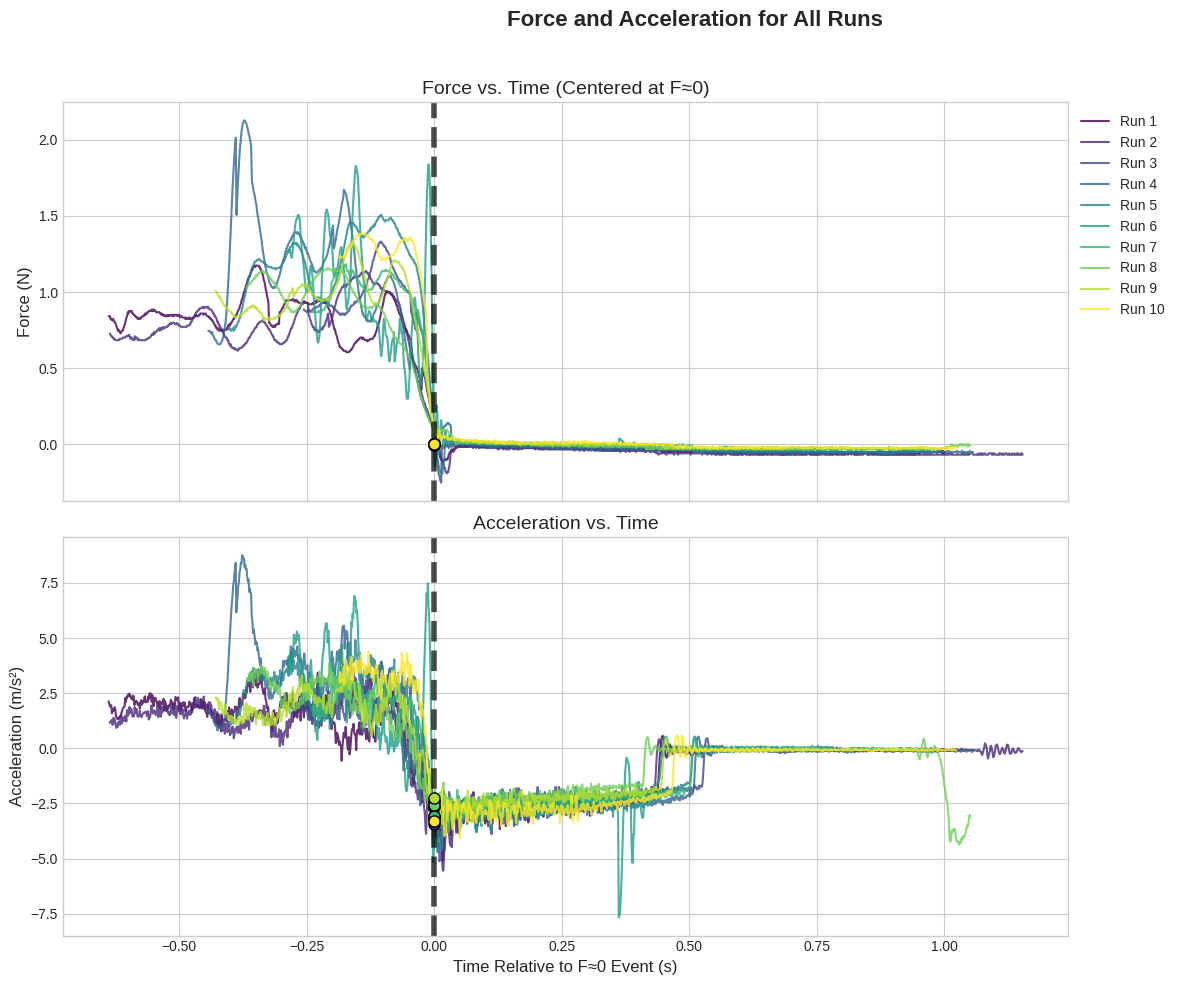

In [414]:
runstart = 0
runend = 10
plot_all_runs(filtered_forces[runstart:runend], filtered_accelerations[runstart:runend])

In [415]:
data = [pd.read_csv(f"data/2{number}Vel.csv") for number in range(1, 6)]
# cal[1] is the velocity column
# cal[2] is the acceleration column

trimmed_runs = []
for df in data:
    # Find the index for the max and min velocity
    max_vel_index = df[' cal[1]'].idxmax()
    min_vel_index = df[' cal[1]'].idxmin()

    # Ensure the slice is chronological by finding the true start and end
    start_index = min(max_vel_index, min_vel_index)
    end_index = max(max_vel_index, min_vel_index)
    
    # Trim the DataFrame and add it to our list
    trimmed_data = df.loc[start_index+5:end_index-5]

    # We set the start time to zero here
    trimmed_data[' time'] -= trimmed_data[' time'].iloc[0]
    trimmed_runs.append(trimmed_data)

/tmp/ipykernel_47413/2134454299.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_data[' time'] -= trimmed_data[' time'].iloc[0]
/tmp/ipykernel_47413/2134454299.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_data[' time'] -= trimmed_data[' time'].iloc[0]
/tmp/ipykernel_47413/2134454299.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [416]:
# We calculate the average acceleration on the left and right of velocity zero

average_accelerations_above = []
average_accelerations_below = []
uncertainty = 0.25

for df in trimmed_runs:
    # Get all data points where velocity is positive (right side)
    above_side = df[df[' cal[1]'] > 0].copy() # Use .copy() to avoid SettingWithCopyWarning
    # Get all data points where velocity is negative (left side)
    below_side = df[df[' cal[1]'] < 0].copy() # Use .copy() to avoid SettingWithCopyWarning

    # Add uncertainty to acceleration data
    # Note: It's better to assign the new column back to the copied dataframe
    above_side['accel_uncertain'] = above_side[' cal[2]'].apply(lambda x: unc.ufloat(x, uncertainty))
    below_side['accel_uncertain'] = below_side[' cal[2]'].apply(lambda x: unc.ufloat(x, uncertainty))

    # --- FIX IS HERE ---
    # Calculate the average by summing the ufloat objects and dividing by the count
    if not above_side.empty:
        avg_accel_above = sum(above_side['accel_uncertain']) / len(above_side)
        average_accelerations_above.append(avg_accel_above)

    if not below_side.empty:
        avg_accel_below = sum(below_side['accel_uncertain']) / len(below_side)
        average_accelerations_below.append(avg_accel_below)

average_accelerations_above, average_accelerations_below

([-3.2158015384615384+/-0.04003203845127178,
  -3.0987014285714283+/-0.03857583749052297,
  -3.0934352777777776+/-0.041666666666666664,
  -3.1793045652173912+/-0.036860489038724284,
  -3.297133333333334+/-0.03857583749052297],
 [-2.480422000000001+/-0.035355339059327376,
  -2.2715158333333334+/-0.03227486121839514,
  -2.352875306122448+/-0.03571428571428571,
  -2.2923688333333327+/-0.03227486121839514,
  -2.4579879245283025+/-0.03434014098717226])

In [419]:
def plot_velocity_acceleration_with_uncertainty(runs_data, avg_above, avg_below, title="Velocity and Acceleration with Uncertainty"):
    """
    Plots raw velocity and acceleration and overlays the calculated average
    accelerations with their uncertainty bands.
    
    Args:
        runs_data (list): A list of pandas DataFrames for each run.
        avg_right (ufloat): The overall average acceleration for v > 0.
        avg_left (ufloat): The overall average acceleration for v < 0.
        title (str): The main title for the plot.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    colors = cm.viridis(np.linspace(0, 1, len(runs_data)))

    # --- Plot the raw data for each run ---
    for i, df in enumerate(runs_data):
        run_label = f"Run {i+1}"
        axs[0].plot(df[' time'], df[' cal[1]'], label=run_label, color=colors[i], alpha=0.8)
        axs[1].plot(df[' time'], df[' cal[2]'], label=run_label, color=colors[i], alpha=0.8)

    # --- Plot the calculated average and uncertainty on the acceleration plot ---
    if avg_above is not None:
        # Plot horizontal line for the mean (v > 0)
        axs[1].axhline(y=avg_above.n, color='cornflowerblue', linestyle='--', linewidth=2.5, 
                       label=f'Avg. Accel (Uphill, Accel > 0): {avg_above:.2u}')
        # Plot shaded region for the uncertainty
        axs[1].axhspan(avg_above.n - avg_above.s, avg_above.n + avg_above.s, 
                       color='cornflowerblue', alpha=0.25)

    if avg_below is not None:
        # Plot horizontal line for the mean (v < 0)
        axs[1].axhline(y=avg_below.n, color='salmon', linestyle='--', linewidth=2.5, 
                       label=f'Avg. Accel (Downhill, Accel < 0): {avg_below:.2u}')
        # Plot shaded region for the uncertainty
        axs[1].axhspan(avg_below.n - avg_below.s, avg_below.n + avg_below.s, 
                       color='salmon', alpha=0.25)

    # --- Formatting ---
    # Velocity plot
    axs[0].set_ylabel("Velocity (m/s)", fontsize=12)
    axs[0].set_title("Velocity Between Peaks", fontsize=14)
    axs[0].legend(loc='upper right')

    # Acceleration plot
    axs[1].set_ylabel("Acceleration (m/s²)", fontsize=12)
    axs[1].set_title("Corresponding Acceleration and Calculated Averages", fontsize=14)
    axs[1].set_xlabel("Time (s)", fontsize=12)
    axs[1].legend(loc='upper right')
    
    fig.suptitle(title, fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig("velocity_acceleration_uncertainty_plot.png")
    plt.show()

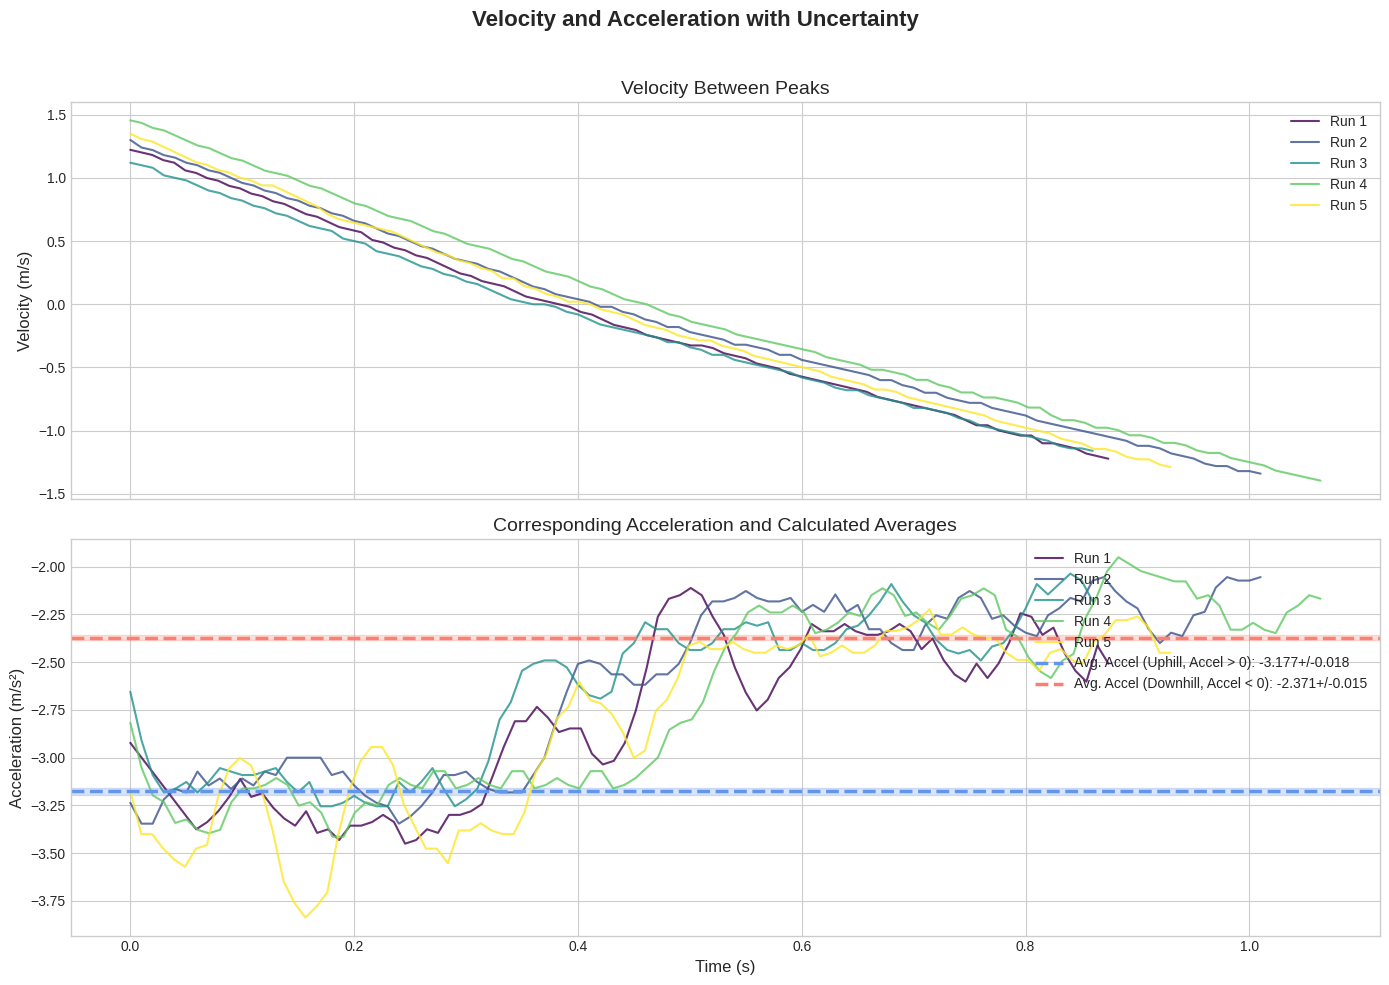

(-3.1768752286722934+/-0.01751977322003867,
 -2.3710339794634834+/-0.015215898028619716)

In [421]:
overall_avg_above = None
if average_accelerations_above:
    overall_avg_above = sum(average_accelerations_above) / len(average_accelerations_above)

overall_avg_below = None
if average_accelerations_below:
    overall_avg_below = sum(average_accelerations_below) / len(average_accelerations_below)
plot_velocity_acceleration_with_uncertainty(trimmed_runs, overall_avg_above, overall_avg_below)
overall_avg_above, overall_avg_below